In [240]:
%reload_ext autoreload
%autoreload 2
%aimport -sklearn, matplotlib, numpy, seaborn

In [281]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import assessment 
import calibration 
%matplotlib inline

In [242]:
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({"axes.grid" : True, "grid.linestyle": '--', 
                     "grid.alpha": 0.8, "grid.color": "black"})
mpl.rcParams.update({"lines.linewidth" : 3})

In [243]:
data = np.loadtxt('default.csv', delimiter=',', dtype=str, skiprows=2)
np.random.seed()
_X = data[:,1:-1]
_Y = data[:,-1].astype('int')
np.sum(_Y)/_Y.size

0.2212

In [244]:
# read all train and test data into a single matrix
data = np.loadtxt('default.csv', delimiter=',', dtype=str, skiprows=2)
np.random.seed()
X = data[:,1:-1]
Y = data[:,-1].astype('int')

# undersample class Y = 0
# Y0indices = np.where(Y == 0)[0]
# Y1indices = np.where(Y == 1)[0]
# Y0indices = np.random.choice(Y0indices, size=15000-len(Y1indices))
# X_subsampled = X[np.concatenate((Y0indices, Y1indices)), :]
# Y_subsampled = Y[np.concatenate((Y0indices, Y1indices))]

# indices = np.arange(X_subsampled.shape[0])
# np.random.shuffle(indices)
# X = X_subsampled[indices,:]
# Y = Y_subsampled[indices]

X = preprocessing.scale(X)

# create splits
XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y, test_size=10000)
XTrain, XClient, YTrain, YClient = train_test_split(
    XTrain, YTrain, test_size=5000)
XTrain, XCalib, YTrain, YCalib = train_test_split(
    XTrain, YTrain, test_size=5000)

Train accuracy:  0.8137
Calibration accuracy:  0.8154


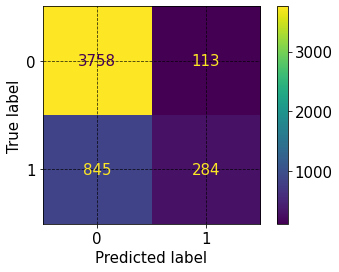

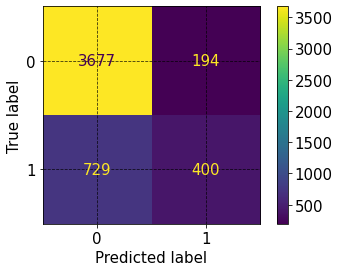

In [245]:
#clf = RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=50).fit(XTrain, YTrain)
clf_lr = LogisticRegression(random_state=0, solver='lbfgs').fit(XTrain, YTrain)
clf_gbdt = GradientBoostingClassifier().fit(XTrain, YTrain)

print('Train accuracy: ', clf_lr.score(XTrain, YTrain))
print('Calibration accuracy: ', clf_gbdt.score(XCalib, YCalib))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(YCalib, clf_lr.predict(XCalib))).plot()
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(YCalib, clf_gbdt.predict(XCalib))).plot()

# Backward compatibility in ranking

In [246]:
calib_probs_lr = clf_lr.predict_proba(XTest)[:,1]
calib_probs_gbdt = clf_gbdt.predict_proba(XTest)[:,1]

In [247]:
order_lr = calib_probs_lr.argsort(kind='stable')
ranks_probs_lr = order_lr.argsort()

In [248]:
order_gbdt = calib_probs_gbdt.argsort(kind='stable')
ranks_probs_gbdt = order_gbdt.argsort()

In [249]:
inspection_array = np.stack((calib_probs_lr, ranks_probs_lr, calib_probs_gbdt, ranks_probs_gbdt, YTest)).T
inspection_array = inspection_array[order_lr,:]
#np.set_printoptions(suppress=True)
#print(inspection_array[:100,:])

In [250]:
def spearman_coeff(rank1, rank2): 
    assert(len(rank1.shape) == 1)
    assert(len(rank2.shape) == 1)
    assert(rank1.size == rank2.size)
    n = rank1.size
    return 1 - (np.sum(6*(rank1-rank2)**2)/((n**3)-n))

spearman_coeff(ranks_probs_lr, ranks_probs_gbdt)

0.6321970265019703

In [274]:
def rank_deviation_score(rank1, rank2): 
    assert(len(rank1.shape) == 1)
    assert(len(rank2.shape) == 1)
    assert(rank1.size == rank2.size)
    n = rank1.size
    
    return np.sum(np.abs(rank1-rank2))/(n*n)
    
print("RDS(LR, GBDT) = {:.3f}".format(rank_deviation_score(ranks_probs_lr, ranks_probs_gbdt)))    

RDS(LR, GBDT) = 0.185


In [261]:
# inspection_array_ = np.stack((calib_probs_lr_hb, ranks_probs_lr_hb, calib_probs_gbdt_hb, ranks_probs_gbdt_hb, YTest)).T
# inspection_array_ = inspection_array_[order_lr_hb,:]
# np.set_printoptions(suppress=True)
# print(inspection_array_[:100,:])

In [280]:
calib_probs_lr_hb = clfHB_lr.predict_proba(XTest)
#calib_probs_lr_hb_noisy = calib_probs_lr_hb + 1e-10*np.random.randn((calib_probs_lr_hb.size))
order_lr_hb = calib_probs_lr_hb.argsort(kind='stable')
ranks_probs_lr_hb = order_lr_hb.argsort()

calib_probs_gbdt_hb = clfHB_gbdt.predict_proba(XTest)
#calib_probs_lr_gbdt_noisy = calib_probs_lr_gbdt + 1e-10*np.random.randn((calib_probs_lr_gbdt.size))
order_gbdt_hb = calib_probs_gbdt_hb.argsort(kind='stable')
ranks_probs_gbdt_hb = order_gbdt_hb.argsort()

calib_probs_gbdt = clf_gbdt.predict_proba(XTest)[:,1]
#calib_probs_lr_gbdt_noisy = calib_probs_lr_gbdt + 1e-10*np.random.randn((calib_probs_lr_gbdt.size))
order_gbdt = calib_probs_gbdt.argsort(kind='stable')
ranks_probs_gbdt = order_gbdt.argsort()


print("RDS(LR+HB, GBDT+HB) = {:.3f}".format(rank_deviation_score(ranks_probs_lr_hb, ranks_probs_gbdt_hb)))
print("RDS(LR+HB, GBDT) = {:.3f}".format(rank_deviation_score(ranks_probs_lr_hb, ranks_probs_gbdt)))
print("RDS(LR, GBDT+HB) = {:.3f}".format(rank_deviation_score(ranks_probs_lr, ranks_probs_gbdt_hb)))

RDS(LR+HB, GBDT+HB) = 0.151
RDS(LR+HB, GBDT) = 0.244
RDS(LR, GBDT+HB) = 0.251


# Recalibration 

[ 752. 1186. 1506. 2006. 1911.  820.  286.  222.  251.  325.  239.  173.
  119.   75.   43.   25.   25.   12.   11.   13.]
Using 15 adaptive bins for ECE estimation.
Classifier has discrete output. Further binning not done for plotting reliability diagram.
[4987. 5013.]
Classifier has discrete output. Further binning not done for ECE estimation.
[ 354. 2513. 2359. 1407.  813.  507.  314.  233.  153.  126.  112.  149.
  244.  217.  214.  156.   93.   33.    2.    1.]
Using 15 adaptive bins for ECE estimation.
Classifier has discrete output. Further binning not done for plotting reliability diagram.
[4949. 5051.]
Classifier has discrete output. Further binning not done for ECE estimation.


Text(0.5, 1.0, 'GBDT + recalibration: 0.0067')

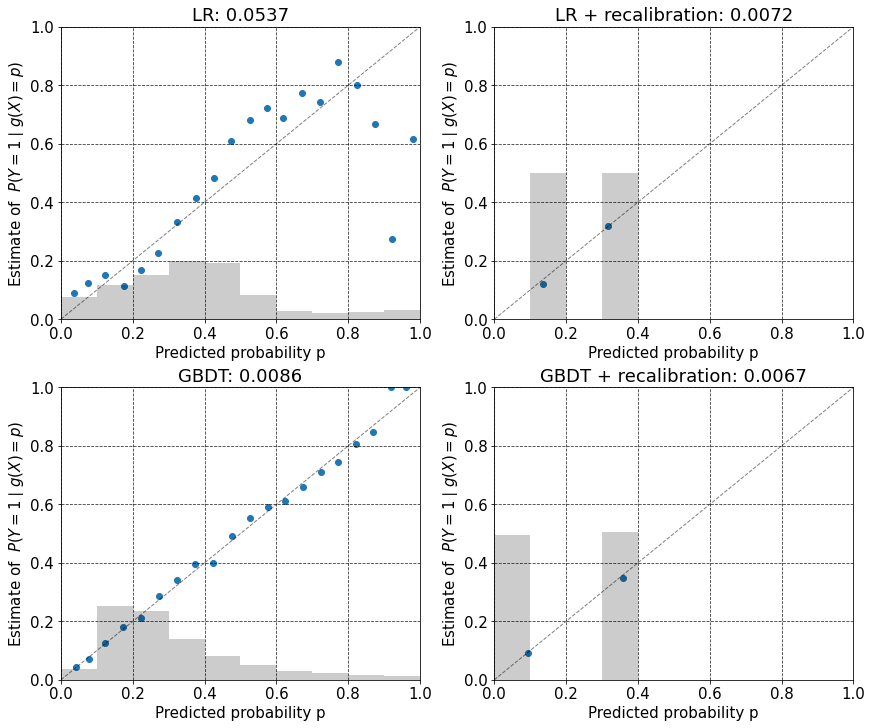

In [279]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10), constrained_layout=True)

# get predicted probabilities for class 1 for logistic
predProb = clf_lr.predict_proba(XTest)[:,1]
assessment.reliability_diagram(YTest, predProb, ax[0,0], n_bins=20, fixed=True)
ax[0,0].set_title("LR: {:.4f}".format(assessment.ece(YTest, predProb)))
clfHB_lr = calibration.Recalibrated_Classifier()
clfHB_lr.base_clf = clf_lr
clfHB_lr.n_bins = 2
clfHB_lr.calibration_type = 'umd'
clfHB_lr.fit(XCalib,YCalib)

predProbHB = clfHB_lr.predict_proba(XTest)
assessment.reliability_diagram(YTest, predProbHB, ax[0,1])
ax[0,1].set_title("LR + recalibration: {:.4f}".format(assessment.ece(YTest, predProbHB)))

# get predicted probabilities for class 1 for logistic
predProb = clf_gbdt.predict_proba(XTest)[:,1]
assessment.reliability_diagram(YTest, predProb, ax[1,0], n_bins=20, fixed=True)
ax[1,0].set_title("GBDT: {:.4f}".format(assessment.ece(YTest, predProb)))

clfHB_gbdt = calibration.Recalibrated_Classifier()
clfHB_gbdt.base_clf = clf_gbdt
clfHB_gbdt.n_bins = 2
clfHB_gbdt.calibration_type = 'umd'
clfHB_gbdt.fit(XCalib,YCalib)
#fig, ax = plt.subplots(figsize=(5.5,5))
#x_grid = np.linspace(0, 1, 1000)[1:-1]
#y_eval = clfHB.predict_proba(None, x_grid)

predProbHB = clfHB_gbdt.predict_proba(XTest)
assessment.reliability_diagram(YTest, predProbHB, ax[1,1])
#ax.plot(x_grid, y_eval, '--', label='Histogram binning (B = 50)', color='g', linewidth=1)
ax[1,1].set_title("GBDT + recalibration: {:.4f}".format(assessment.ece(YTest, predProbHB)))